Othman Murad

# Homework 1:  Power System Event Classification with Convolutional Neural Network Using PMU Data

## Notebook Outline

    1. Load Needed Libraries/Packages

    2. Load pmuBAGE Dataset
    
    3. Visualization of the PMU events

    4. Dataset Pre-processing

    5. Define the Neural Network

    6. Train the Neural Network

    7. Evaluate the Neural Network

## 1. Load Needed Libraries/Packages

In [1]:
# Load the tensorflow, which is a framework for deep learning.
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
# Load numpy library as "np", which can handle large matrices and provides some mathematical functions.
import numpy as np 
# Load pandas as "pd", which is useful when working with data tables. 
import pandas as pd 
# Load random, which provide some randomize functions.
import random
# Load a function pyplot as "plt" to plot figures.
import matplotlib.pyplot as plt

# Setup the random seed for reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


2024-04-28 01:50:07.415602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load the pmuBAGE Data
    31 tensors for voltage events and 21 tensors for frequency events.
    Each voltage tensor contains 20 events and each frequency tensor contains 4 events.
    There are 620 voltage and 84 frequency event samples.

### Download the dataset: 
> Download the dataset from https://github.com/NanpengYu/pmuBAGE.git, and put it same path of this notebook.

In [2]:
# The root directory of the pmuBAGE data
pmuBAGE_data_dir = "pmuBAGE/data"

# Number of the tensor for voltage and frequency
voltage_tensor_number = 31
frequency_tensor_number = 21

# Load each tensors of voltage events and concatenate them as a big tensor.
voltage_tensor_list = []
for idx in range(voltage_tensor_number):
    voltage_sub_tensor = np.load(f"{pmuBAGE_data_dir}/voltage/voltage_{idx}.npy")
    voltage_tensor_list.append(voltage_sub_tensor)
voltage_tensor = np.concatenate(voltage_tensor_list, axis=0)

# Load each tensors of frequency events and concatenate them as a big tensor.
frequency_tensor_list = []
for idx in range(frequency_tensor_number):
    frequency_sub_tensor = np.load(f"{pmuBAGE_data_dir}/frequency/frequency_{idx}.npy")
    frequency_tensor_list.append(frequency_sub_tensor)
frequency_tensor = np.concatenate(frequency_tensor_list, axis=0)

# Transpose the big tensor as (event_idx, timestamp, PMU_idx, measurements)
voltage_tensor = np.transpose(voltage_tensor, (0, 3, 2, 1))
frequency_tensor = np.transpose(frequency_tensor, (0, 3, 2, 1))

# Print the shape of the voltage event
print(voltage_tensor.shape)
print(frequency_tensor.shape)

(620, 600, 100, 4)
(84, 600, 100, 4)


## 3. Visualization of the PMU Event Sample

In [3]:
def visualization(event, save_path='', isSave=False):
    plt.style.context(['ieee', 'no-latex'])

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.55)
    plt.tick_params(labelsize=15)

    axes[0].set_title("Real Power", fontsize=20)
    axes[0].plot(event[:, :, 0])
    axes[0].tick_params(labelsize=12)
    axes[0].set_xlabel('Timestamp', fontsize=15)
    axes[0].xaxis.set_label_coords(0.92, -0.21)

    axes[1].set_title("Reactive Power", fontsize=20)
    axes[1].plot(event[:, :, 1])
    axes[1].tick_params(labelsize=12)
    axes[1].set_xlabel('Timestamp', fontsize=15)
    axes[1].xaxis.set_label_coords(0.92, -0.21)

    axes[2].set_title("Voltage Magnitude", fontsize=20)
    axes[2].plot(event[:, :, 2])
    axes[2].tick_params(labelsize=12)
    axes[2].set_xlabel('Timestamp', fontsize=15)
    axes[2].xaxis.set_label_coords(0.92, -0.21)

    axes[3].set_title("Frequency", fontsize=20)
    axes[3].plot(event[:, :, 3])
    axes[3].tick_params(labelsize=12)
    axes[3].set_xlabel('Timestamp', fontsize=15)
    axes[3].xaxis.set_label_coords(0.92, -0.21)

    if isSave == True:
        plt.savefig(f"{pmuBAGE_data_dir}/images")
    plt.show()
    
    return

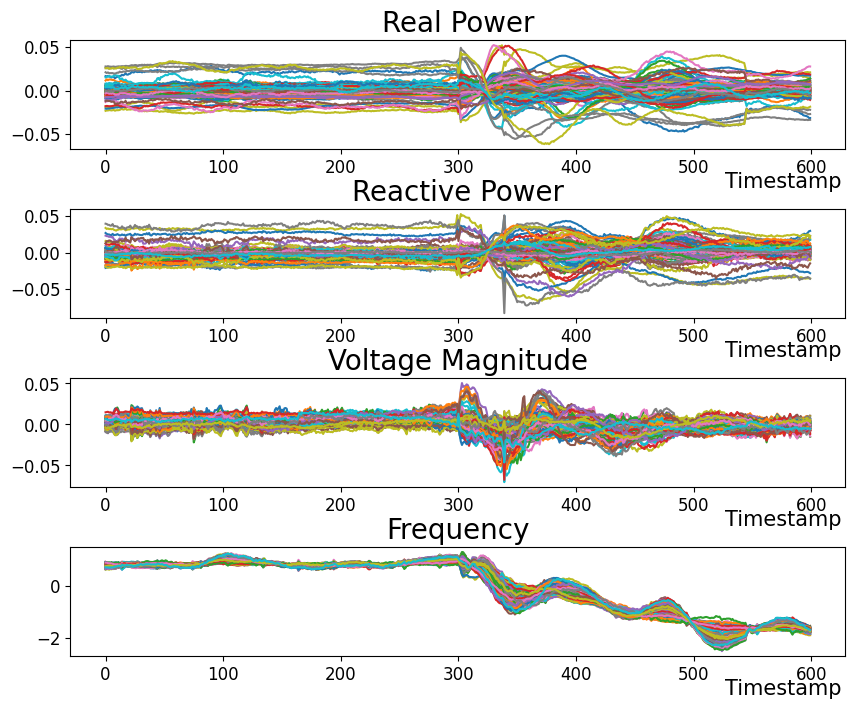

In [15]:
visualization(frequency_tensor[1])

## 4. Dataset Pre-processing (Input Samples and Labels)

### 4.1 Dataset standardization

In [4]:
##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##

"""
    Use standardization to pre-process the pmu time series data.
    Input  -> two original tensors: voltage_tensor, frequency_tensor
    Output -> two standardized tensors: voltage_tensor_standardized, frequency_tensor_standardized
    Requirement Details: 
        The tensor shape is (number_of_event, timestamps (600), pmus (100), measurements (4))
        For each time sequence (Single pmu measurement sequence, 600 timestamps), standardize them by Z-Score
        z-score = (x - mean) / std
"""

# Voltage tensor
voltage_tensor_standardized = (voltage_tensor - np.mean(voltage_tensor, axis=1, keepdims=True)) / np.std(voltage_tensor, axis=1, keepdims=True)

# Frequency tensor
frequency_tensor_standardized = (frequency_tensor - np.mean(frequency_tensor, axis=1, keepdims=True)) / np.std(frequency_tensor, axis=1, keepdims=True)


##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##

# Should be (620, 600, 100, 4)
print(voltage_tensor_standardized.shape)
# Should be (84, 600, 100, 4)
print(frequency_tensor_standardized.shape)


(620, 600, 100, 4)
(84, 600, 100, 4)


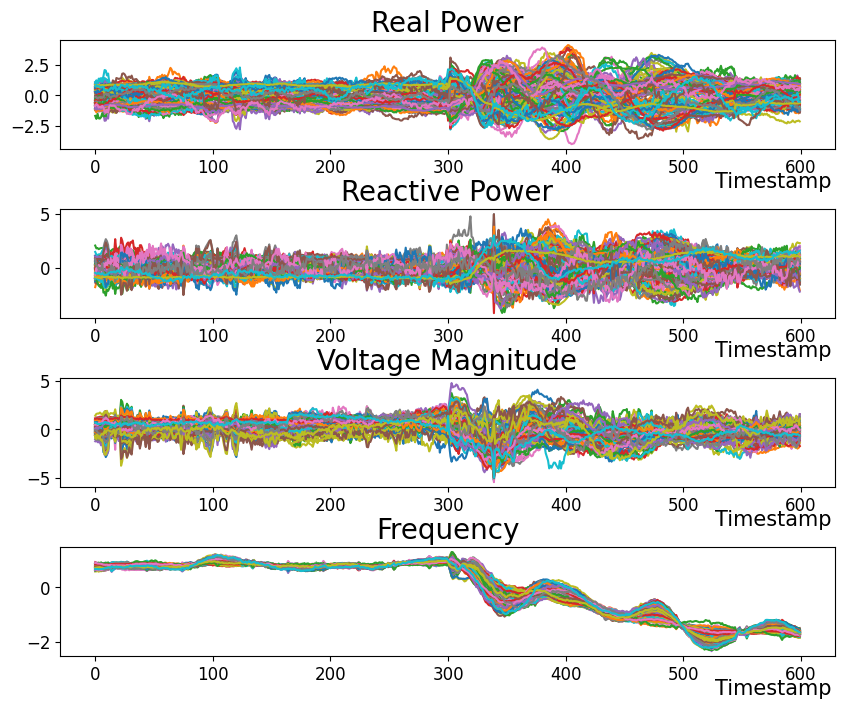

In [5]:
# Visualize the standardized event and compare the difference.
visualization(frequency_tensor_standardized[1])

### 4.2 One-hot Encoding for Different Event Types

In [6]:
# Number of the classes
num_classes = 2

# Number of the voltage and frequency events in the dataset
n_voltage = voltage_tensor_standardized.shape[0]
n_frequency = frequency_tensor_standardized.shape[0]

# Define the labels
# Voltage events' label is defined as: 0
voltage_label = np.array([0] * n_voltage)
# Frequency events' label is defined as: 1
frequency_label = np.array([1] * n_frequency)

##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##


"""
    Implement the one-hot encoding on the lablel of of the voltage and frequency event labels.
    Input  -> Original voltage and frequency labels (voltage_label, frequency_label)
    Output -> One-hot encoded voltage and frequency labels (voltage_label_onehot, frequency_label_onthot)
    Voltage label: "0" -> "[1, 0]"
    Frequency label: "1" -> "[0, 1]"
    You can use any library or tool for doing this
"""
from tensorflow.keras.utils import to_categorical

voltage_label_onehot = to_categorical(voltage_label, num_classes=num_classes)
frequency_label_onthot = to_categorical(frequency_label, num_classes=num_classes)



##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##


# Should be [1, 0]
print(voltage_label_onehot[0])
# Should be [0, 1]
print(frequency_label_onthot[0])
# Should be (620, 2)
print(voltage_label_onehot.shape)
# Should be (84, 2)
print(frequency_label_onthot.shape)

[1. 0.]
[0. 1.]
(620, 2)
(84, 2)


### 4.3 Permutation over the voltage and frequency tensor

In [7]:
voltage_tensor_standarded_permuted = voltage_tensor_standardized[np.random.permutation(n_voltage)]
frequency_tensor_standarded_permuted = frequency_tensor_standardized[np.random.permutation(n_frequency)]

### 4.4 Seperate the Train and Test dataset

In [8]:
# Seperate the data to train and test
train_portion = 0.7

# Samples
X_voltage = voltage_tensor_standarded_permuted
X_frequency = frequency_tensor_standarded_permuted
# Labels
y_voltage = voltage_label_onehot
y_frequency = frequency_label_onthot

##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##


"""
    Seperate the samples and labels to train and test datasets.
    70% of the voltage and frequency samples and labels are combined as training dataset
    30% remainings are combined as testing dataset
    Input  -> X_voltage, X_frequency, y_voltage, y_frequency
    Output -> X_train, y_train, X_test, y_test
        X_train contains 70% of the X_voltage and X_frequency
        y_train contains 70% of the y_voltage and y_frequency
        X_test contains 30% of the X_voltage and X_frequency
        y_test contains 30% of the y_voltage and y_frequency
"""

# Calculate the number of voltage and frequency samples for training
n_voltage_train = int(n_voltage * train_portion)
n_frequency_train = int(n_frequency * train_portion)

# Separate voltage samples and labels into train and test sets
X_voltage_train = X_voltage[:n_voltage_train]
X_voltage_test = X_voltage[n_voltage_train:]
y_voltage_train = y_voltage[:n_voltage_train]
y_voltage_test = y_voltage[n_voltage_train:]

# Separate frequency samples and labels into train and test sets
X_frequency_train = X_frequency[:n_frequency_train]
X_frequency_test = X_frequency[n_frequency_train:]
y_frequency_train = y_frequency[:n_frequency_train]
y_frequency_test = y_frequency[n_frequency_train:]

# Combine voltage and frequency samples and labels for training
X_train = np.concatenate((X_voltage_train, X_frequency_train), axis=0)
y_train = np.concatenate((y_voltage_train, y_frequency_train), axis=0)

# Combine voltage and frequency samples and labels for testing
X_test = np.concatenate((X_voltage_test, X_frequency_test), axis=0)
y_test = np.concatenate((y_voltage_test, y_frequency_test), axis=0)




##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##

# Should be (492, 600, 100, 4)
print(X_train.shape)
# Should be (492, 2)
print(y_train.shape)
# Should be (212, 600, 100, 4)
print(X_test.shape)
# Should be (212, 2)
print(y_test.shape)

(492, 600, 100, 4)
(492, 2)
(212, 600, 100, 4)
(212, 2)


## 5. Define the Neural Network

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(600, 100, 4)))

##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##

"""
    Add more laybers in the model, at least three convolusional layers.
    Then add the Flatten and Dense layers to make the output same with the number of classes.
"""
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))




"""
    Define the Loss function
"""

loss_func = 'categorical_crossentropy'


"""
    Define the optimizer and learning rate
"""
lr = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)



##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##

# Summary of the model
model.summary()
# Compile the neural network model
model.compile(optimizer=optimizer, loss=loss_func, metrics=['categorical_accuracy'])


/Users/othmanmurad/Downloads/MLforPMU/MLforPMU/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 598, 98, 32)    │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 596, 96, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 298, 48, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 296, 46, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 148, 23, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 146, 21, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 73, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,990,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,056,130 (11.66 MB)

 Trainable params: 3,056,130 (11.66 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the neural network

In [11]:
# Thanks to the Keras, the training only need one-line code.

model.fit(X_train, y_train, epochs=10, batch_size=16)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3633
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3630
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3628
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3623
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3621
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3619
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3616
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3615
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - categorical_accuracy: 0.8847 - loss: 0.3613
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - categorical_accuracy: 0.8847 - loss: 0.3611


## 7. Evaluate the Neural Network

In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"The accuracy of the neural network on the test dataset is: {accuracy}.")

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - categorical_accuracy: 0.9654 - loss: 0.2062
The accuracy of the neural network on the test dataset is: 0.8773584961891174.
